# Machine Learning For Trading

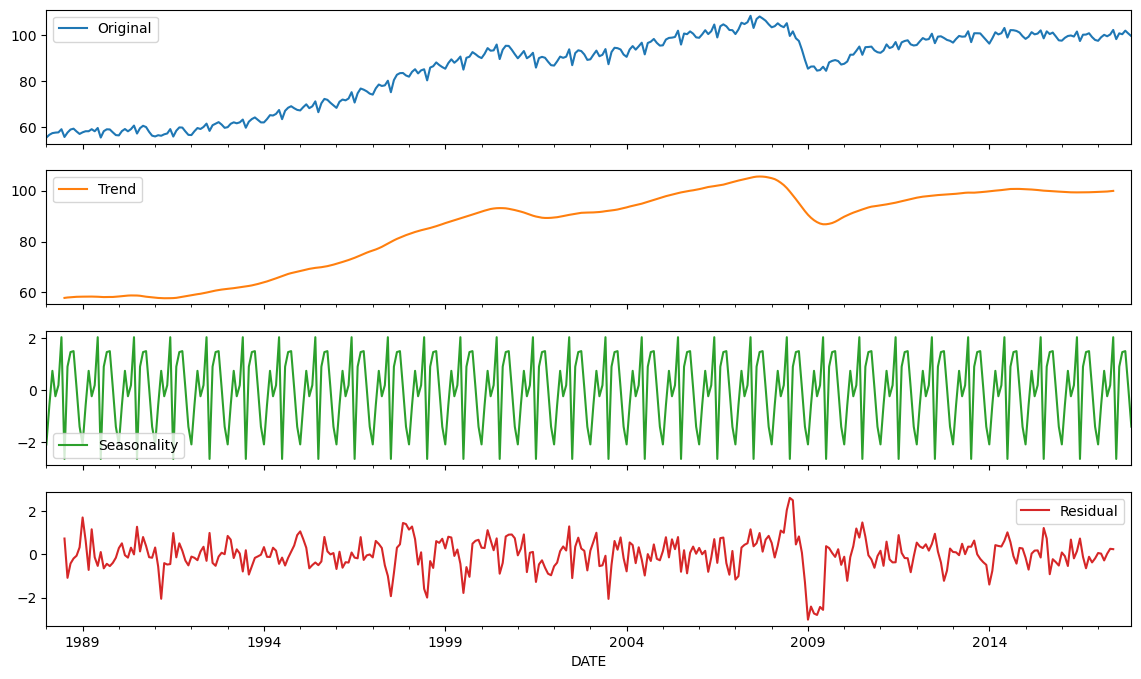

In [5]:
import pandas_datareader.data as web
import statsmodels.tsa.api as tsa

industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze()
components = tsa.seasonal_decompose(industrial_production, model='additive')
ts = (industrial_production.to_frame('Original')
 .assign(Trend=components.trend)
 .assign(Seasonality=components.seasonal)
 .assign(Residual=components.resid))
ts.plot(subplots=True, figsize=(14, 8));

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from arch import arch_model
import pandas_datareader.data as web

nasdaq = web.DataReader('NASDAQCOM', 'fred', '2015', '2020').squeeze()
nasdaq_returns = np.log(nasdaq).diff().dropna().mul(100) 
trainsize = 3 * 252 # 10 years
data = nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05), upper=nasdaq_returns.quantile(.95))
T = len(nasdaq_returns)
results = {}
for p in range(2, 3):
    for q in range(2, 3):
        print(f'{p} | {q}')
        result = []
        for s, t in enumerate(range(trainsize, T-1)):
            train_set = data.iloc[s: t]
            test_set = data.iloc[t+1] # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

2 | 2


In [16]:
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
import pandas as pd

am = ConstantMean(nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05), upper=nasdaq_returns.quantile(.95)))
am.volatility = GARCH(2, 0, 2)
am.distribution = Normal()
best_model = am.fit(update_freq=5)
print(best_model.summary())

Iteration:      5,   Func. Count:     45,   Neg. LLF: 1439.5583954122712
Iteration:     10,   Func. Count:     83,   Neg. LLF: 1424.6943449021578
Iteration:     15,   Func. Count:    117,   Neg. LLF: 1424.685978150334
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1424.6859781498922
            Iterations: 15
            Function evaluations: 117
            Gradient evaluations: 15
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              NASDAQCOM   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1424.69
Distribution:                  Normal   AIC:                           2861.37
Method:            Maximum Likelihood   BIC:                           2891.98
                                        No. Observations:                 1214
Date:             

In [17]:
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '2020', '2024-10').dropna()
df.columns = ['sentiment', 'ip']

## backtesting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
CSI300 = pd.read_csv('CSI300.csv')
CSI300.head()

,Ticker,Company,Segment,Exchange,Weighting (%)
0,SSE: 600519,Kweichow Moutai,Consumer Staples,Shanghai,5.972
1,SSE: 601318,Ping An Insurance,Financials,Shanghai,2.590
2,SZSE: 300750,CATL,Industrials,Shenzhen,2.421
3,SSE: 600036,China Merchants Bank,Financials,Shanghai,2.225
4,SZSE: 000333,Midea Group,Consumer Discretionary,Shenzhen,1.727


In [5]:
def yf_ticker(ticker):
    return ticker[-6:] + "." +ticker[:2]

In [8]:
CSI300['yf_ticker'] = CSI300['Ticker'].apply(lambda x: yf_ticker(x))
CSI300.to_csv('CSI300.csv')

In [9]:
from datetime import datetime, timedelta

df = pd.read_csv('CSI300.csv')

tickers = df['yf_ticker'].unique()
end_date = datetime.today().date()
start_date = end_date - timedelta(days=365)

all_data = pd.DataFrame()

for ticker in tickers:
    stock_data = yf.download(ticker, start_date, end_date)
    stock_data['Ticker'] = ticker
    all_data = pd.concat([all_data, stock_data])

all_data.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [11]:
all_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
71995,2024-11-04,17.959999,18.100000,17.68,17.910000,17.910000,7518208,001289.SZ
71996,2024-11-05,17.830000,17.950001,17.60,17.940001,17.940001,9881373,001289.SZ
71997,2024-11-06,17.879999,18.080000,17.50,17.680000,17.680000,10393920,001289.SZ
71998,2024-11-07,17.690001,18.500000,17.66,18.400000,18.400000,15953143,001289.SZ
71999,2024-11-08,18.389999,18.600000,17.98,18.049999,18.049999,11083114,001289.SZ


In [12]:
CSI_300_his_price = all_data

In [15]:
CSI_300_his_price['Return'] = CSI_300_his_price['Close'].pct_change() # percentage change  
CSI_300_his_price.dropna(inplace=True) 
CSI_300_Return = CSI_300_his_price

In [16]:
CSI_300_Return.to_csv('CSI_300_Return.csv')

In [56]:
df = pd.read_csv('CSI_300_Return.csv')

lowest_returns_per_day = df.groupby('Date').apply(lambda x: x.nlargest(10, 'Return'))

lowest_returns_per_day.reset_index(drop = True, inplace=True)

In [57]:
lowest_returns_per_day.drop(columns='Unnamed: 0', inplace=True)

In [58]:
lowest_returns_per_day.reset_index(drop=True)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Return
0,2023-11-13,256.690002,258.980011,255.639999,257.130005,256.502014,3423343,002371.SZ,44.189807
1,2023-11-13,244.000000,244.589996,238.330002,240.600006,235.378143,3226766,600809.SS,37.009480
2,2023-11-13,161.000000,161.000000,156.600006,157.300003,151.458694,5110451,000661.SZ,31.233606
3,2023-11-13,170.699997,173.300003,169.500000,171.720001,171.329254,5242698,688012.SS,21.926570
4,2023-11-13,144.880005,144.990005,138.600006,139.899994,139.540802,7377963,300782.SZ,18.566432
...,...,...,...,...,...,...,...,...,...
2395,2024-11-08,49.799999,54.779999,49.330002,52.680000,52.680000,47357702,601689.SS,0.057619
2396,2024-11-08,24.900000,27.000000,24.900000,25.980000,25.980000,331382048,601138.SS,0.054383
2397,2024-11-08,438.989990,468.000000,427.000000,447.750000,447.750000,15459373,002371.SZ,0.051081
2398,2024-11-08,76.010002,82.500000,76.010002,79.440002,79.440002,142410319,603019.SS,0.050794


In [59]:
lowest_returns_per_day.to_csv('lowest_returns_per_day.csv')

In [60]:
CSI_300_Return = pd.read_csv('CSI_300_return.csv')
lowest_returns_per_day = pd.read_csv('lowest_returns_per_day.csv')

initial_capital = 100000
portfolio_value = initial_capital
investment_data = []
portfolio_value_data = []

trading_dates = sorted(lowest_returns_per_day['Date'].unique())

for i in range(len(trading_dates)-1):
    current_date = trading_dates[i]
    next_date = trading_dates[i+1]

    daily_lowest_returns = lowest_returns_per_day[lowest_returns_per_day['Date'] == current_date]

    investment_per_stock = portfolio_value / 10

    daily_investments =[]

    for index, row in daily_lowest_returns.iterrows():
        ticker = row['Ticker']
        close_price = row['Close']

        num_shares = investment_per_stock / close_price

        investment_record = {
            'Date': current_date,
            'Ticker': ticker,
            'Close Price': close_price,
            'Investment Amount': investment_per_stock,
            'Shares Purchased': num_shares 
        }
        daily_investments.append(investment_record)

    investment_data.extend(daily_investments)

    next_day_prices = CSI_300_Return[CSI_300_Return['Date'] == next_date]
    portfolio_value = 0

    for record in daily_investments:
        ticker = record['Ticker']
        num_shares = record['Shares Purchased']

        next_day_close_price = next_day_prices[next_day_prices['Ticker'] == ticker]['Close']
        if not next_day_close_price.empty:
            next_day_close_price = next_day_close_price.values[0]
        else:
            next_day_close_price = record['Close Price'] 

        portfolio_value += num_shares * next_day_close_price

    portfolio_value_data.append({
        'Date': next_date,
        'Portfolio Value': portfolio_value
    })

investment_df = pd.DataFrame(investment_data)
portfolio_value_df = pd.DataFrame(portfolio_value_data)




In [62]:
portfolio_value_df.to_csv('portfolio_value1.csv')

Text(0.5, 1.0, 'Stock Price Chart')

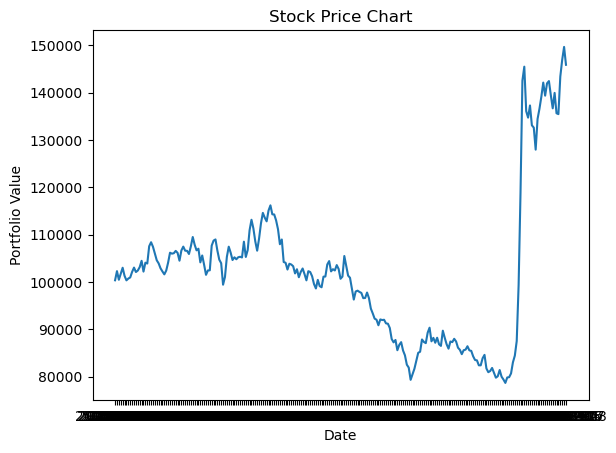

In [63]:
# read the data from csv and draw the chart

data = pd.read_csv('portfolio_value1.csv')

# draw the chart
plt.plot(data['Date'], data['Portfolio Value'])
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Stock Price Chart')

[*********************100%%**********************]  1 of 1 completed


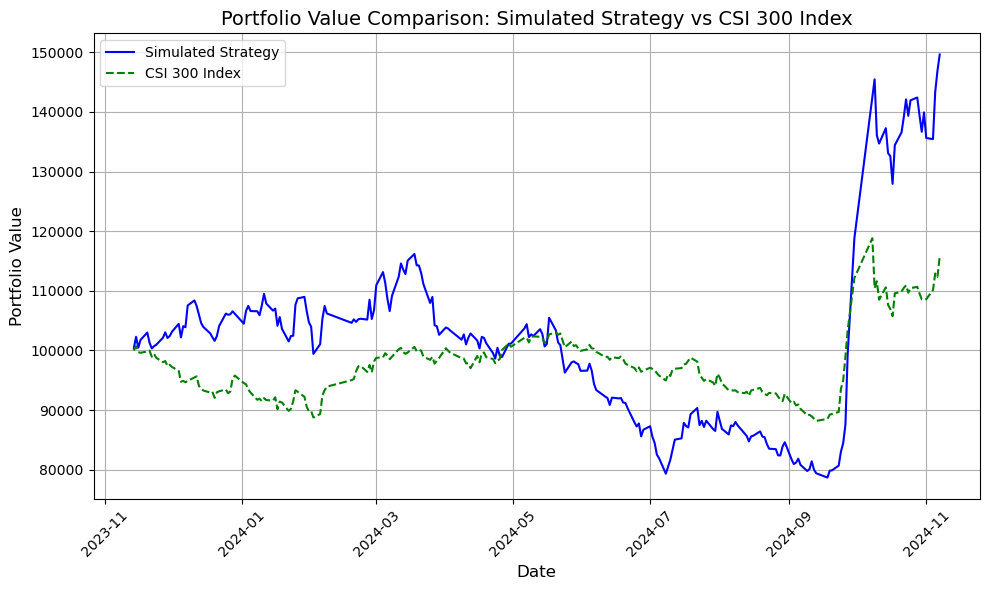

In [64]:
portfolio_value_df = pd.read_csv('portfolio_value1.csv')

csi_300_ticker = '000300.SS'
csi_300_data = yf.download(csi_300_ticker, start=portfolio_value_df['Date'].min(), end=portfolio_value_df['Date'].max())

# Extract the 'Adj Close' price for the CSI 300 index and calculate the portfolio value
initial_investment = 100000
csi_300_data['Portfolio Value'] = initial_investment * csi_300_data['Adj Close'] / csi_300_data['Adj Close'].iloc[0]

# Merge the simulated strategy portfolio value with the CSI 300 index portfolio value on the 'Date'
portfolio_value_df['Date'] = pd.to_datetime(portfolio_value_df['Date'])
csi_300_data.reset_index(inplace=True)
csi_300_data['Date'] = pd.to_datetime(csi_300_data['Date'])

merged_df = pd.merge(portfolio_value_df, csi_300_data[['Date', 'Portfolio Value']], on='Date', how='inner', suffixes=('_Simulated', '_CSI300'))

# Plot the portfolio values of both strategies
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], merged_df['Portfolio Value_Simulated'], label='Simulated Strategy', color='blue')
plt.plot(merged_df['Date'], merged_df['Portfolio Value_CSI300'], label='CSI 300 Index', color='green', linestyle='--')

# Add labels and title
plt.title('Portfolio Value Comparison: Simulated Strategy vs CSI 300 Index', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# NLP


In [1]:
import requests

# Set your API endpoint and parameters
url = 'https://newsapi.org/v2/top-headlines'
params = {
    'country': 'us',           # You can change the country or other parameters
    'apiKey': 'b4b580e3e61442328828ad4d1774df27'   # Replace with your NewsAPI key
}

# Request headlines
response = requests.get(url, params=params)
data = response.json()

# Extract headlines from the response
headlines = [article['title'] for article in data.get('articles', []) if article.get('title')]
print("Headlines:", headlines)


Headlines: ['Trump appears to read from Tesla sales pitch at White House event: ‘They gave me notes’ - Hindustan Times', 'Exclusive | Celebrity chef got death threats after criticizing Meghan Markle’s Netflix show: ‘I’ve nothing against Meghan’ - New York Post ', 'Rosie O’Donnell reveals why she moved to Ireland: ‘It’s been pretty wonderful’ - CNN', 'Department of Education lays off nearly 50% of its workforce - ABC News', '2025 NFL free agency tracker: Updates on top 100 free agents, including Joey Bosa and DeAndre Hopkins - CBS Sports', 'Chromecast (2nd gen) and Audio cannot Cast in ‘Untrusted’ outage [Update] - 9to5Google', 'Rep. Sarah McBride misgendered by Republican colleague during committee hearing - ABC News', 'Emily Osment celebrates birthday with brother Haley Joel Osment after settling divorce with husband of 5 months - Page Six', 'In a striking change of tone, Tesla mega bull Dan Ives warns Elon Musk that patience is ‘wearing thin’ - Fortune', 'SpaceX mission set to launch

In [4]:
import spacy
import numpy as np

# Load the spaCy model (make sure to download it first: python -m spacy download en_core_web_md)
nlp = spacy.load('en_core_web_md')

# Process each headline and obtain its vector representation
headline_vectors = [nlp(headline).vector for headline in headlines]
# Optionally, compute an average vector if you're aggregating multiple headlines
if headline_vectors:
    aggregated_vector = np.mean(headline_vectors, axis=0)
    print("Aggregated vector shape:", aggregated_vector.shape)

Aggregated vector shape: (300,)
